# B.4. Equity Options

## Module: FX, Commodities, and Equities

### DRW New-Hire Learning Program

#### Summer 2022

Questions?
* Contact: Mark Hendricks
* hendricks@uchicago.edu

$\newcommand{\dvd}{D}$
$\newcommand{\pvdvd}{D^*}$
$\newcommand{\pvstrike}{K^*}$
$\newcommand{\strike}{K}$

$\newcommand{\nargcond}{d_{1}}$
$\newcommand{\nargexer}{d_{2}}$

$\newcommand{\EcondS}{\hat{S}_{\text{conditional}}}$
$\newcommand{\probexer}{\hat{\mathcal{P}}_{\text{exercise}}}$

In [1]:
import pandas as pd
import numpy as np
import datetime
import warnings

import yfinance as yf

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator)

import sys
sys.path.insert(0,'../cmds')
from options import *

# Equity Options

## Basic Structure

### Call option

A **call option** on an asset gives the holder of the call the right, but not the obligation, to buy the **underlying** asset at a pre-specified price.
- The call option must be purchased from a counterparty willing to *write* the call.
- The price paid to buy the call is the **premium**.
- Note the difference from forwards and swaps, which have no cost at initiation. The call option clearly has value at initialization, given that it is an option without obligation.

### Put option

A **put option** on an asset gives the holder of the put the right, but not the obligation, to *sell* the **underlying** asset at a pre-specified price.

### Strike
The **strike price** (also known as the **exercise price**,) is the agreed price at which the call holder can buy the asset.
- Note that the strike is a parameter of the contract--it is certain.
- The strike is the future cost, (paid at exercise,) not a present value. 

If the security underlying the call has a price above the strike price, it is said to be **in the money**.

In [2]:
TICK = 'AMZN'
sec = yf.Ticker(TICK)

DATE = pd.to_datetime(datetime.date.today())
EXPRYDATE = '2022-08-26'
tau = (pd.to_datetime(EXPRYDATE) - DATE).total_seconds()/(24*60*60)/365

In [3]:
px = sec.history('1d')['Close'].values[0]

tbill = yf.Ticker('^IRX').history('1d')['Close'].iloc[-1]/100

In [4]:
import pandas_datareader.data as web
import pandas_datareader as pdr

START_DATE = '2022-07-15'
END_DATE = '2022-07-21'
TICKRF = 'SOFR'
sofr = pdr.DataReader(TICKRF,data_source='fred', start=START_DATE,end=END_DATE).iloc[-1].values[0]/100

In [5]:
USESOFR = True

if USESOFR:
    rf = sofr
else:
    rf = tbill

disc = np.exp(-rf*tau)

In [6]:
def filter_stale_quotes(opt_chain):
    LDATE =opt_chain.sort_values('lastTradeDate')['lastTradeDate'].iloc[-1]
    mask = list()

    for idx in opt_chain.index:
        dt = opt_chain.loc[idx,'lastTradeDate']
        if (dt - LDATE).total_seconds()/3600 > -24:
            mask.append(idx)
    
    return mask

In [7]:
def clean_options(calls_raw,puts_raw):
    idx = filter_stale_quotes(calls_raw)
    calls = calls_raw.loc[idx,:]
    idx = filter_stale_quotes(puts_raw)
    puts = puts_raw.loc[idx,:]

    calls = calls[calls['volume'] > calls['volume'].quantile(.25)].set_index('contractSymbol')
    puts = puts[puts['volume'] > puts['volume'].quantile(.25)].set_index('contractSymbol')
    
    calls['lastTradeDate'] = calls['lastTradeDate'].dt.tz_localize(None)
    puts['lastTradeDate'] = puts['lastTradeDate'].dt.tz_localize(None)
    
    return calls, puts

In [8]:
opts = sec.option_chain(EXPRYDATE)
calls_raw = opts.calls
puts_raw = opts.puts

calls, puts = clean_options(calls_raw,puts_raw)

In [9]:
base = 5
pxrounded = base * math.floor(px / base)
idCall = calls['strike'].sub(pxrounded).abs().idxmin()
K = calls.loc[idCall,'strike']
ivolC = calls.loc[idCall,'impliedVolatility']

idPut = puts['strike'].sub(px).abs().idxmin()
ivolP = puts.loc[idPut,'impliedVolatility']

expry = EXPRYDATE
grid_px = np.arange(px/1.5,px*(4/3),.1)

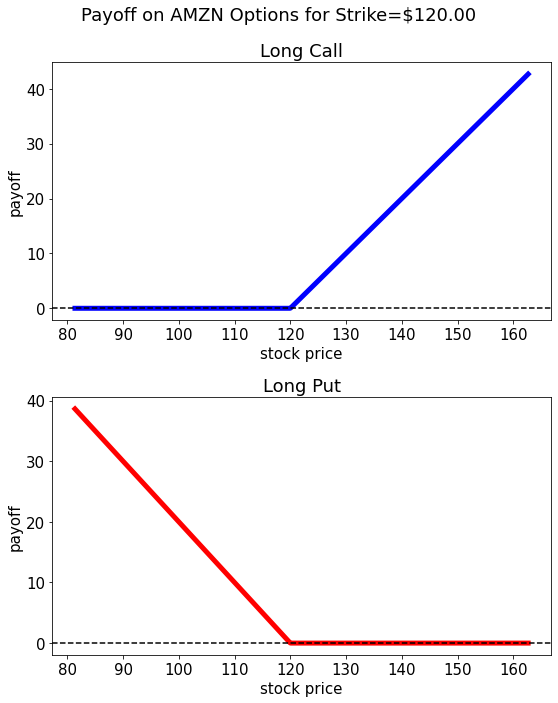

In [10]:
fig,ax = plt.subplots(2,figsize=(8,10))
ex_call = pd.Series(index=grid_px,data=[max(px-K,0) for px in grid_px])
ex_call.plot(ax=ax[0],title='Long Call',xlabel='stock price',ylabel='payoff',linewidth=5,color='b')
ex_put = pd.Series(index=grid_px,data=[max(K-px,0) for px in grid_px])
ex_put.plot(ax=ax[1],title='Long Put',xlabel='stock price',ylabel='payoff',linewidth=5,color='r')
ax[0].axhline(0,color='k',linestyle='--')
ax[1].axhline(0,color='k',linestyle='--')

plt.suptitle(f'Payoff on {TICK} Options for Strike=${K:,.2f}')
plt.tight_layout()
plt.show()

### Expiration
The call option has an **expiration** date. 

Most traded equity options have short-term expirations--weeks or a few months.


### Style
Consider two *styles* of options,

**European**: stipulates that the option can only be exercised at the expiration date.
- Useful starting point for considering the pricing and risk of equity options.
- In practice, more common to see European style for stock index options and foreign currency options.

**American**: allows the option to be exercised any time up to the expiration date.
- Most equity options traded in the U.S. are American style.
- Do not have closed-form solutions, so require numerical methods.

**Other styles**
- Not our focus, but will see so-called *Bermudan*, *Asian*, etc.

These labels have nothing to do with *where* the options trade.

## Option Payoffs and Prices 

Notation
- $c_0$: price of a European call
- $p_0$: price European put
- $\strike$: strike price of both the put and call
- $S_o$: price of stock at time of valuation
- $r$: continuously compounded risk-free interest rate
- $T$: time until expiration (in years)

### Value at expiration

The price at expiration is given by the definition of the option.

#### Call
$$c_T = \max(S_T - \strike, 0)$$

#### Put
$$p_T = \max(\strike-S_T, 0)$$

Note that this expiration price is nonlinear in the underlying, $S$, due to the $\max$ and $\min$ functions

### Bounds

What is the value of the option before expiration?
- This question will require a serious pricing model: Black-Scholes is the baseline, and we discuss is later.
- First, focus conceptually on the price boundaries.


#### European options

|                  | lower bound | upper bound |
|------------------|------|-----|
| Call price at $t$, $c_t$ |$$\max(S_t-\pvstrike_t, 0)$$| $$S_t$$ |
| Put price at $t$, $p_t$  |$$\max(\pvstrike-S_t, 0)$$ | $$\pvstrike_t$$|


#### American options
The American options may be exercised early, as soon as the present.
- Thus, the present value of the strike may be $\strike$ rather than $\pvstrike$.

|                  | lower bound | upper bound |
|------------------|------|-----|
| Call price at $t$, $C_t$ |$$\max(S_t-\strike_t, 0)$$| $$S_t$$ |
| Put price at $t$, $P_t$  |$$\max(\strike-S_t, 0)$$ | $$\strike_t$$|

### A long put is NOT a short call
A put option is not the same as selling, or writing, a call option.
- The **buyer of a put option** has 
    - *limited upside*: The underlying price can only go to zero
    - *limited downside*: Losing the premium if the option stays out of the money.
    
- The **seller of a call** has 
    - *unlimited downside*: The underlying asset can appreciate without limit
    - *limited upside*: The premium gained by writing the call.

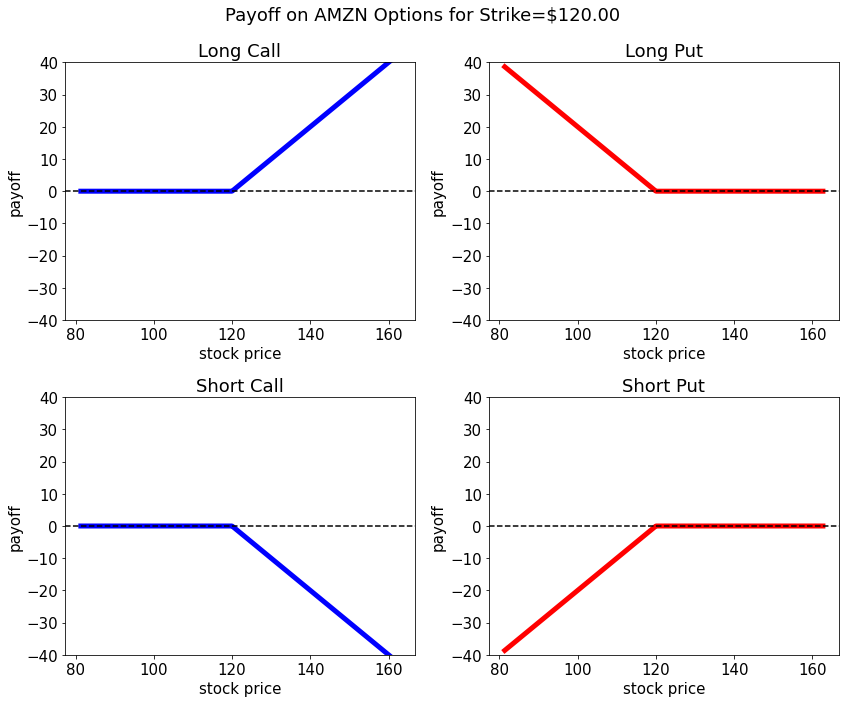

In [11]:
yb = 40

fig,ax = plt.subplots(2,2,figsize=(12,10))
ex_call.plot(ax=ax[0,0],title='Long Call',xlabel='stock price',ylabel='payoff',ylim=(-yb,yb),linewidth=5,color='b')
ex_put.plot(ax=ax[0,1],title='Long Put',xlabel='stock price',ylabel='payoff',ylim=(-yb,yb),linewidth=5,color='r')
(-ex_call).plot(ax=ax[1,0],title='Short Call',xlabel='stock price',ylabel='payoff',ylim=(-yb,yb),linewidth=5,color='b')
(-ex_put).plot(ax=ax[1,1],title='Short Put',xlabel='stock price',ylabel='payoff',ylim=(-yb,yb),linewidth=5,color='r')

ax[0,0].axhline(0,color='k',linestyle='--')
ax[0,1].axhline(0,color='k',linestyle='--')
ax[1,0].axhline(0,color='k',linestyle='--')
ax[1,1].axhline(0,color='k',linestyle='--')

plt.suptitle(f'Payoff on {TICK} Options for Strike=${K:,.2f}')
plt.tight_layout()
plt.show()

## Option Value

Consider how the following features impact the value of the call and put.

Consider whether each cell of the table should have a "+" or "-".

|                  | call | put |
|------------------|------|-----|
| american style   |      |     |
| strike           |      |     |
| expiration       |      |     |
| stock volatility |      |     |
| interest rate    |      |     |
| stock dividend   |      |     |


We will have much more to say about these sensitivities, once we have the Black-Scholes pricing formula to quantify them.

### Option price as a function of strike

Notice that the relationship is nonlinear.
- The payoff function is (piecewise) linear in strike
- Yet the pricing function is nonlinear--particularly when the underlyling stock price is near the strike price.

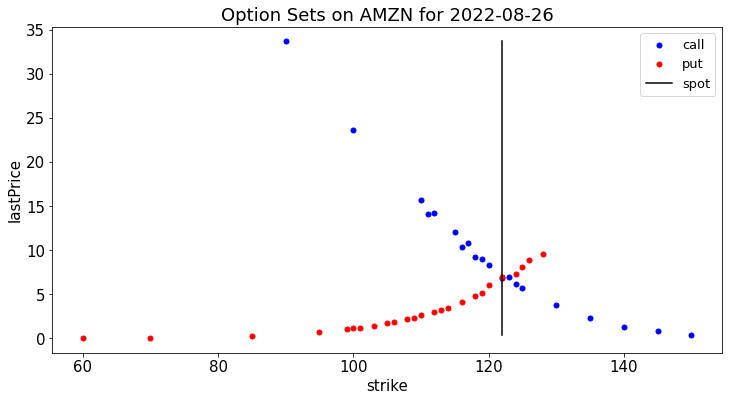

In [12]:
ax = calls[['strike','lastPrice']].plot.scatter(x='strike',y='lastPrice',color='b',s=25)
puts[['strike','lastPrice']].plot.scatter(ax=ax, x='strike',y='lastPrice',color='r',s=25)

grid_min = max(calls['lastPrice'].min(),calls['lastPrice'].min())
grid_max = max(calls['lastPrice'].max(),calls['lastPrice'].max())
grid_plot_spot = pd.Series(data=[grid_min,grid_max],index=[px,px]).T
grid_plot_spot.plot(ax=ax,color='k')

plt.legend(['call','put','spot'])
plt.title(f'Option Sets on {TICK} for {EXPRYDATE}')

plt.show()

### Option price as a function of expiration

The option price is increasing in the time-to-expiration.

In [13]:
dts = ['2022-08-05','2022-08-12','2022-08-19','2022-08-26','2022-09-16','2022-10-21','2022-11-18','2022-12-16','2023-01-20']#,'2023-02-17']
pquote = pd.DataFrame(index=dts,columns=['call','put'],dtype=float)
for dt in dts:
    temp = sec.option_chain(dt).calls
    pquote.loc[dt,'call'] = temp[temp['strike']==K]['lastPrice'].values[0]
    
    temp = sec.option_chain(dt).puts
    pquote.loc[dt,'put'] = temp[temp['strike']==K]['lastPrice'].values[0]

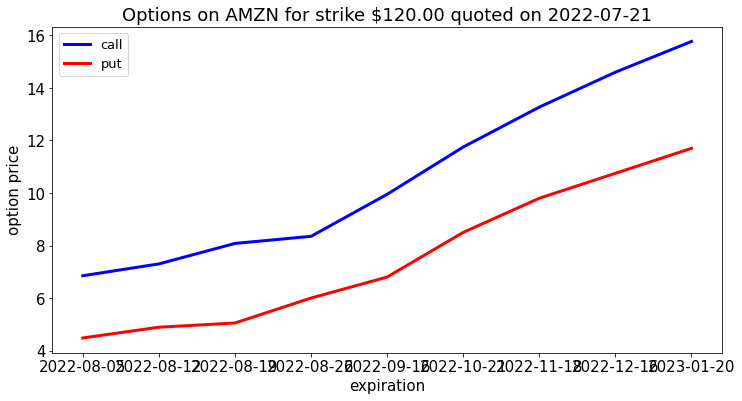

In [14]:
pquote.plot(xlabel='expiration',ylabel='option price',color=['b','r'],linewidth=3)
plt.title(f'Options on {TICK} for strike ${K:,.2f} quoted on {DATE:%Y-%m-%d}')
plt.show()

# Put-Call Parity

## Replication

For a given strike, the price of the call and of the put are closely related.

Replicate a share of stock with...
- long call
- short put
- long cash (a zero coupon bond with face value equal to strike)

This will have the same payoff as the share of stock in every situation.

See the payoff graphs to see this conceptually.

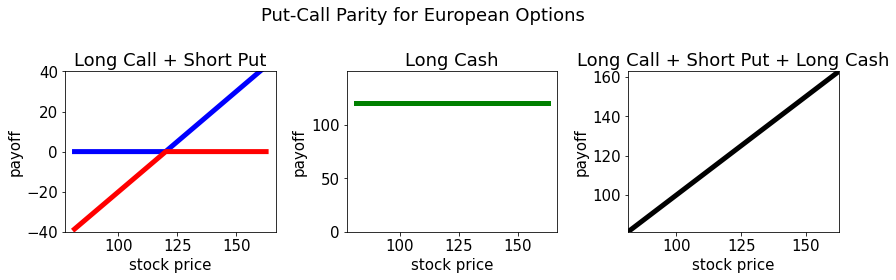

In [15]:
grid_K = pd.Series(index=ex_call.index,data=K)

fig,ax = plt.subplots(1,3,figsize=(12,4))

ex_call.plot(ax=ax[0],linewidth=5,color='b')
(-ex_put).plot(ax=ax[0],linewidth=5,color='r')

#ax[0].axhline(0,color='m',linewidth=6)
ax[0].set_title('Long Call + Short Put')
ax[0].set_ylabel('payoff')
ax[0].set_xlabel('stock price')
ax[0].set_ylim(-yb,yb)

(grid_K).plot(ax=ax[1],linewidth=5,color='g')
ax[1].set_title('Long Cash')
ax[1].set_ylabel('payoff')
ax[1].set_xlabel('stock price')
ax[1].set_ylim(0,K*disc*1.25)

(ex_call-ex_put+grid_K).plot(ax=ax[2],linewidth=5,color='k')
ax[2].set_title('Long Call + Short Put + Long Cash')
ax[2].set_ylabel('payoff')
ax[2].set_xlabel('stock price')
ax[2].set_ylim(grid_px[0],grid_px[-1])
ax[2].set_xlim(grid_px[0],grid_px[-1])

plt.suptitle(f'Put-Call Parity for European Options')
plt.tight_layout()
plt.show()

## The mathematical equation

At expiry, the payoffs are equal

$\begin{align}
c_T + \strike = p_T + S_T
\end{align}$

#### By no-arbitrage,
- if the payoffs are equal at $T$, 
- then they must have the same price today.

Thus, for any interim time, $0\le t\le T$, 

$\begin{align}
c_t + \pvstrike_t = p_t + S_t
\end{align}$

where again,

$\begin{align}
\pvstrike_t \equiv \strike e^{-r(T-t)}
\end{align}$

## Implications

Put-call parity is among the most important results in options pricing.

### Moneyness
The call-put spread equals the (present-value) *moneyness* of the option:

$$c_t-p_t = S_t - \pvstrike_t$$

- if a stock is equal to the strike (*at the money*) then the call is slightly more valuable than the put.

### Trading Strategies

- Can use puts or calls interchangeablly, (with the appropriate position in the underlying.)
 
- Many option strategies require going long calls and short puts, or vice-versa. Put-call parity puts bounds on these strategies.



# Extensions of Basic Put-Call Parity

## Dividends

Suppose that the underlying stock pays dividends, with present value of $\pvdvd$, in the period between the present and the expiration.
- Suppose there are $m$ total dividends in the interval $(0,T]$, happening at times $T_i$ for $1\le i\le m$.

- Then the present value of these dividends is
$$\pvdvd \equiv \sum_{i}^m \dvd_{T_i}e^{-rT_i}$$


### Replication
Then the replication argument above needs adjusted. 
- A long position in the stock will deliver dividends with present value of $\pvdvd$
- The long-short call-put holding will not deliver dividends. 
- Thus, replication will require an additional holding of $\pvdvd$ in cash. 
    - This will earn rate, $r$ to replicate the dividends.
    - Consider it being invested in $m$ zero-coupon bonds, with maturities, $T_i$ for $1\le i\le m$.

One share of stock replicated by
- long call
- short put
- long cash equal to PV of strike
- long cash equal to PV of dividends

### The equation

$$c_t-p_t = S_t - \pvstrike_t - \pvdvd_t$$

which can equivalently be stated in terms of replicating the share,

$$S_t = \underbrace{c_t - p_t}_{\text{call-put spread}} + \underbrace{\pvstrike_t + \pvdvd_t}_{\text{cash for PV of strike and dividend}}$$

## American Put-Call Bounds

The formula above relies on European-style options, as these only exercise at expiry, $T$, which ensures the payoff is perfectly replicated.

For an American option, early exercise may be optimal.
- the present value of the strike will be in the interval $\left[\strike e^{-rT},\strike\right]$, depending on whether the option is exercised at expiry, at present, or in between.

### Assume there is not a dividend
Let $C$ and $P$ denote the prices of an American call and put at identical strike price, $\strike$.



|                  | lower bound | upper bound |
|------------------|------|-----|
| $$C_t-P_t$$ no dvd |$$S_t - \strike$$|  $$S_t - \pvstrike_t$$ |



### Implications
Note that this implies 
- the call-put spread is smaller for American options than European options. 
- if risk-free rates were zero, the same put-call parity would hold for American options. Thus, with very low interest rates, the distinction is not large.


### Example

Consider the following American call and put on the non-dividend paying stock.

In [16]:
K0 = K

px_fields = ['lastPrice']

idx_call = (calls['strike']==K0).idxmax()
idx_put = (puts['strike']==K0).idxmax()

p_call = calls.loc[idx_call,px_fields].mean()
p_put = puts.loc[idx_put,px_fields].mean()

temp = [p_call-p_put, px-K0, px-K0*disc]

In [17]:
tab_bounds_american = pd.DataFrame(data=temp, index=['call - put', 'lower bound', 'upper bound'],columns=[f'{TICK}, {EXPRYDATE}, {K}']).T
tab_bounds_american.style.format('{:,.2f}')

,call - put,lower bound,upper bound
"AMZN, 2022-08-26, 120.0",2.35,2.05,2.23
